In [260]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, acf
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import seaborn as sns
from adjustText import adjust_text
from sklearn.linear_model import LinearRegression

from functools import reduce


df = pd.read_csv('/Users/jojolapatate/Documents/GitHub/The-Endless-Line/The-Endless-Line_jo/final_data_day.csv')
df_15 = pd.read_csv('/Users/jojolapatate/Downloads/final_data_15min.csv')

pd.set_option('display.max_columns', None)

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3635/2229186867.py:21: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_15 = pd.read_csv('/Users/jojolapatate/Downloads/final_data_15min.csv')


Here, we filter on after 2020 (post Covid), and on attractions not closed. Note -> PortAventura reopened in may 2021 so we have data from then on

In [253]:
df_15['DATE'] = pd.to_datetime(df_15['DATE'])
df_15_bis = df_15[df_15['DATE'].dt.year > 2020]
df_15_bis = df_15_bis[df_15_bis['GUEST CARRIED'] != 0]
df_15_bis = df_15_bis[df_15_bis['ATTENDANCE'] != 0]

df_15_bis = df_15_bis[df_15_bis['ADJUST CAPACITY'] != 0]
df_15_bis['Ratio People/Capacity'] =df_15_bis['GUEST CARRIED']/df_15_bis['ADJUST CAPACITY']
df_15_bis = df_15_bis[df_15_bis['Ratio People/Capacity'] <= 1]

In [205]:
df_15_bis.describe() 

,HOUR START OF 1 RIDE,WAIT TIME,NB UNITS,GUEST CARRIED,CAPACITY,ADJUST CAPACITY,OPEN_TIME,REAL TIME ATTRACTION OPEN FOR 15MIN,REAL TIME ATTRACTION CLOSES FOR 15MIN,NB MAX UNITS,TEMPERATURE,TEMPERATURE FELT,TEMPERATURE MINIMUM,TEMPERATURE MAXIMUM,PRESSURE,HUMIDITY,WIND SPEED,WIND DEG,CLOUD PERCENTAGE,ATTENDANCE,IS NIGHT SHOW,IS PARADE 1,IS PARADE 2,Ratio People/Capacity
count,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.000000,363999.0,363999.000000
mean,14.521147,22.462644,18.345155,161.110784,324.249840,303.146594,14.890788,14.758131,0.132657,18.825483,7.693143,5.607082,6.742532,8.734546,1018.230413,84.052105,4.119290,185.497520,69.764588,31633.932269,0.000011,0.016522,0.0,0.529305
std,3.368850,20.003629,31.338673,111.595830,171.921417,169.203171,0.955130,1.432170,1.080382,31.861266,2.164277,2.646921,2.178898,2.156313,6.653026,8.786762,1.204798,54.631035,22.025112,14076.886091,0.003315,0.127472,0.0,0.199481
min,9.000000,0.000000,0.533300,-65.000000,0.000000,2.500000,1.000000,1.000000,0.000000,1.000000,-1.800000,-5.650000,-2.690000,-1.070000,988.000000,29.000000,0.160000,0.000000,0.000000,4659.000000,0.000000,0.000000,0.0,-2.000000
25%,12.000000,5.000000,2.000000,78.999800,225.000000,213.250000,15.000000,15.000000,0.000000,3.000000,7.534682,5.375491,6.569751,8.556166,1017.159478,83.524512,4.237857,185.225420,70.637711,20671.000000,0.000000,0.000000,0.0,0.400000
50%,14.000000,15.000000,6.000000,138.000000,254.749000,254.750000,15.000000,15.000000,0.000000,6.000000,7.534682,5.375491,6.569751,8.556166,1017.159478,83.524512,4.237857,185.225420,70.637711,30480.000000,0.000000,0.000000,0.0,0.547891
75%,17.000000,30.000000,18.000000,224.000000,450.500000,403.000000,15.000000,15.000000,0.000000,18.000000,7.534682,5.375491,6.569751,8.556166,1017.159478,83.524512,4.237857,185.225420,70.637711,45261.000000,0.000000,0.000000,0.0,0.672953
max,22.000000,300.000000,130.000000,731.000000,756.000000,756.000000,15.000000,15.000000,14.000000,130.000000,20.090000,18.990000,18.860000,21.730000,1042.000000,100.000000,11.480000,359.000000,100.000000,64351.000000,1.000000,1.000000,0.0,1.000000


/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3635/1840162223.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_15_bis.corr()


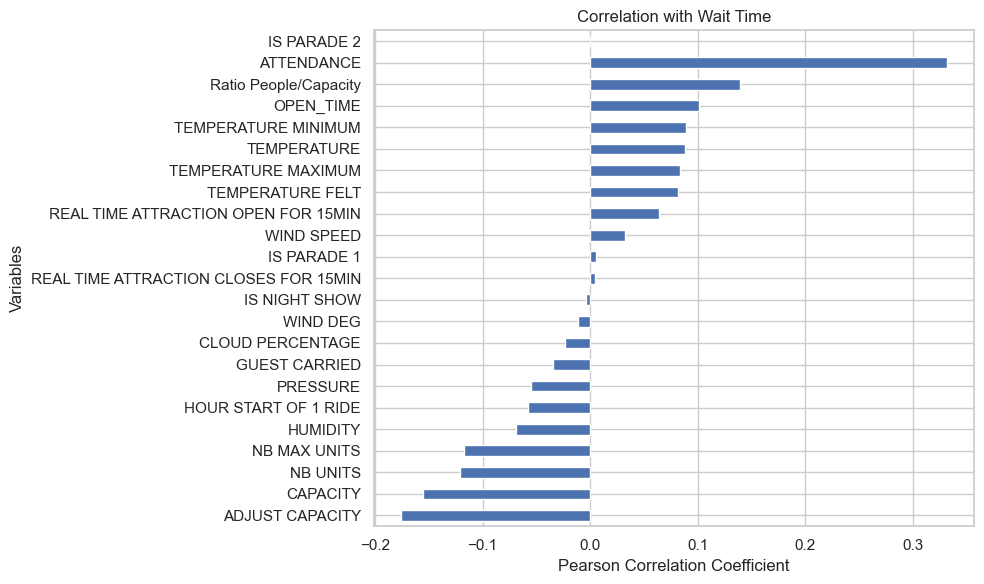

In [254]:
correlation_matrix = df_15_bis.corr()

wait_time_correlation = correlation_matrix['WAIT TIME']
wait_time_correlation = wait_time_correlation.drop('WAIT TIME', errors='ignore')

plt.figure(figsize=(10, 6))
wait_time_correlation.sort_values(ascending=True).plot(kind='barh')
plt.title('Correlation with Wait Time')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Variables')
plt.tight_layout()  
plt.show()


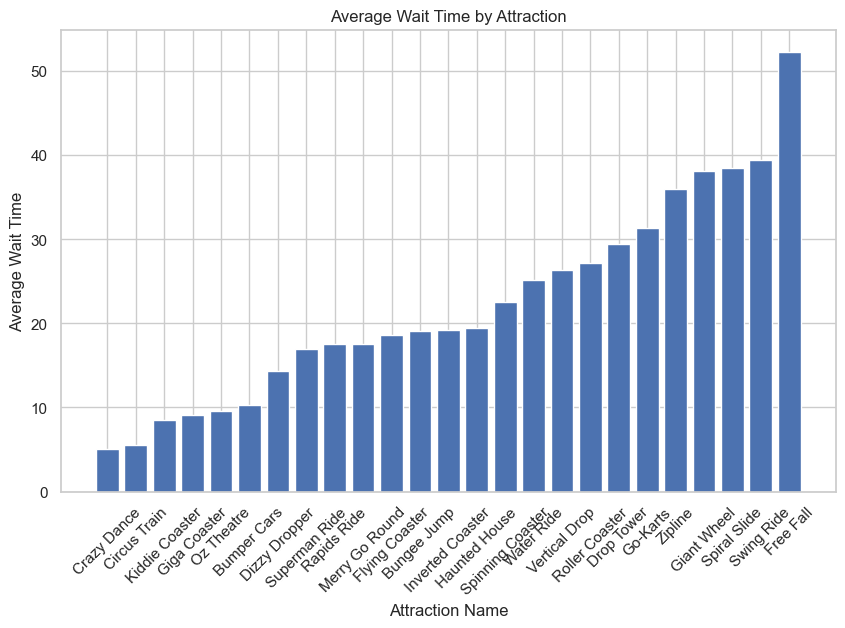

In [255]:
average_wait_time_by_attraction = df_15_bis.groupby('ATTRACTION NAME')['WAIT TIME'].mean().reset_index()
average_wait_time_by_attraction.sort_values(by = 'WAIT TIME', inplace = True)

plt.figure(figsize=(10, 6))
plt.bar(average_wait_time_by_attraction['ATTRACTION NAME'], average_wait_time_by_attraction['WAIT TIME'])
plt.xlabel('Attraction Name')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time by Attraction')
plt.xticks(rotation=45)
plt.show()


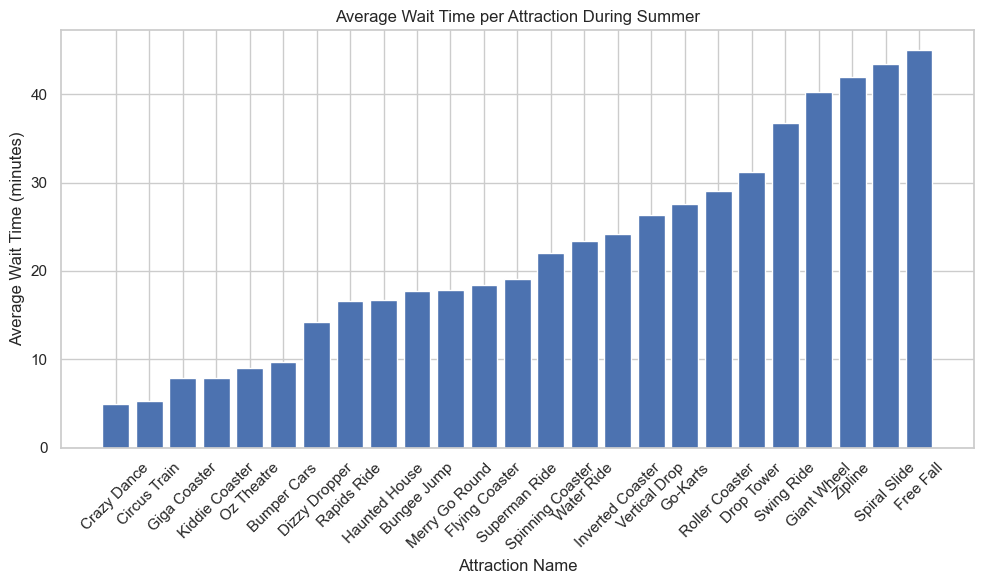

In [208]:
df_filtered = df_15_bis[df_15_bis['DATE'].dt.month.isin([6, 7, 8])]

average_wait_time_summer = df_filtered.groupby(['ATTRACTION NAME'])['WAIT TIME'].mean().reset_index()

average_wait_time_summer.sort_values('WAIT TIME', ascending = True, inplace = True)

plt.figure(figsize=(10, 6))
plt.bar(average_wait_time_summer['ATTRACTION NAME'], average_wait_time_summer['WAIT TIME'])
plt.title('Average Wait Time per Attraction During Summer')
plt.xlabel('Attraction Name')
plt.ylabel('Average Wait Time (minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

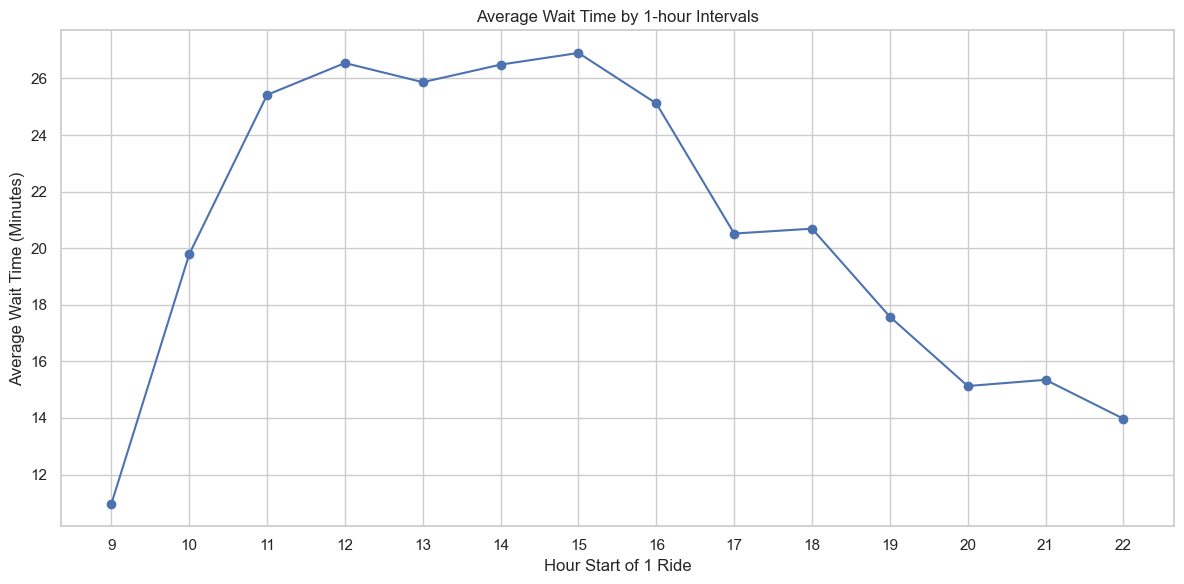

In [256]:
average_wait_time_by_hour = df_15_bis.groupby('HOUR START OF 1 RIDE')['WAIT TIME'].mean().reset_index()

average_wait_time_by_hour.sort_values('HOUR START OF 1 RIDE', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(average_wait_time_by_hour['HOUR START OF 1 RIDE'], average_wait_time_by_hour['WAIT TIME'], marker='o', linestyle='-')
plt.title('Average Wait Time by 1-hour Intervals')
plt.xlabel('Hour Start of 1 Ride')
plt.ylabel('Average Wait Time (Minutes)')
plt.grid(True)
plt.xticks(average_wait_time_by_hour['HOUR START OF 1 RIDE'].unique())  #
plt.tight_layout()
plt.show()


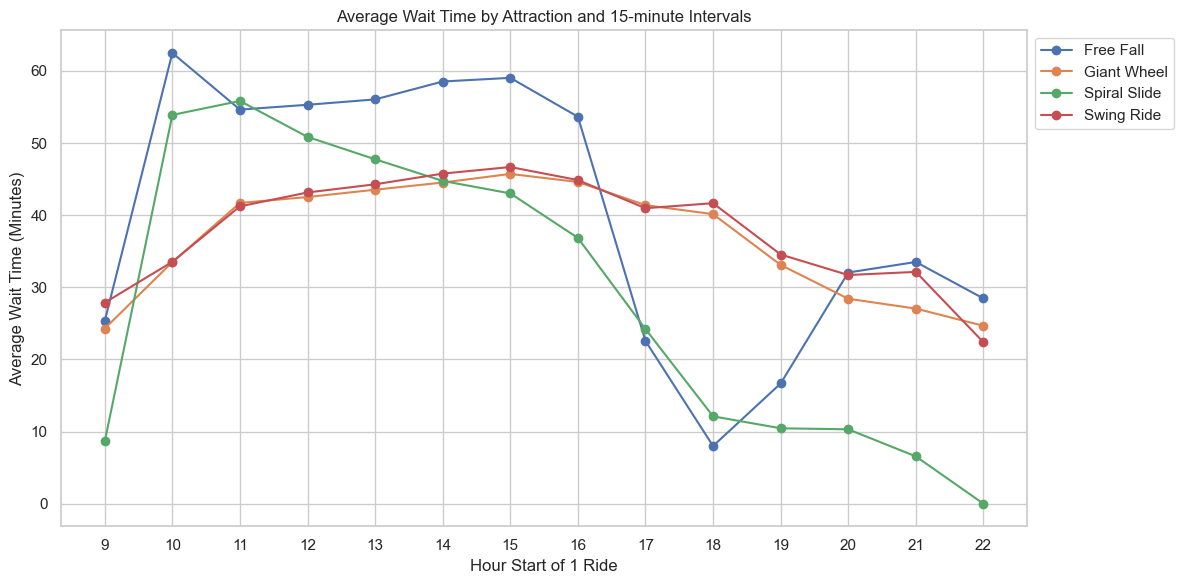

In [257]:
average_wait_time_by_attraction_and_time = df_15_bis.groupby(['ATTRACTION', 'HOUR START OF 1 RIDE'])['WAIT TIME'].mean().reset_index()
selected_attractions = ['Spiral Slide', 'Free Fall', 'Swing Ride', 'Giant Wheel']
average_wait_time_by_attraction_and_time = average_wait_time_by_attraction_and_time[average_wait_time_by_attraction_and_time['ATTRACTION'].isin(selected_attractions)]
average_wait_time_by_attraction_and_time.sort_values(['ATTRACTION', 'HOUR START OF 1 RIDE'], inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

for attraction in average_wait_time_by_attraction_and_time['ATTRACTION'].unique():
    data = average_wait_time_by_attraction_and_time[average_wait_time_by_attraction_and_time['ATTRACTION'] == attraction]
    plt.plot(data['HOUR START OF 1 RIDE'], data['WAIT TIME'], marker='o', linestyle='-', label=attraction)

plt.title('Average Wait Time by Attraction and 15-minute Intervals')
plt.xlabel('Hour Start of 1 Ride')
plt.ylabel('Average Wait Time (Minutes)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
plt.grid(True)
plt.xticks(average_wait_time_by_attraction_and_time['HOUR START OF 1 RIDE'].unique())
plt.tight_layout()
plt.show()


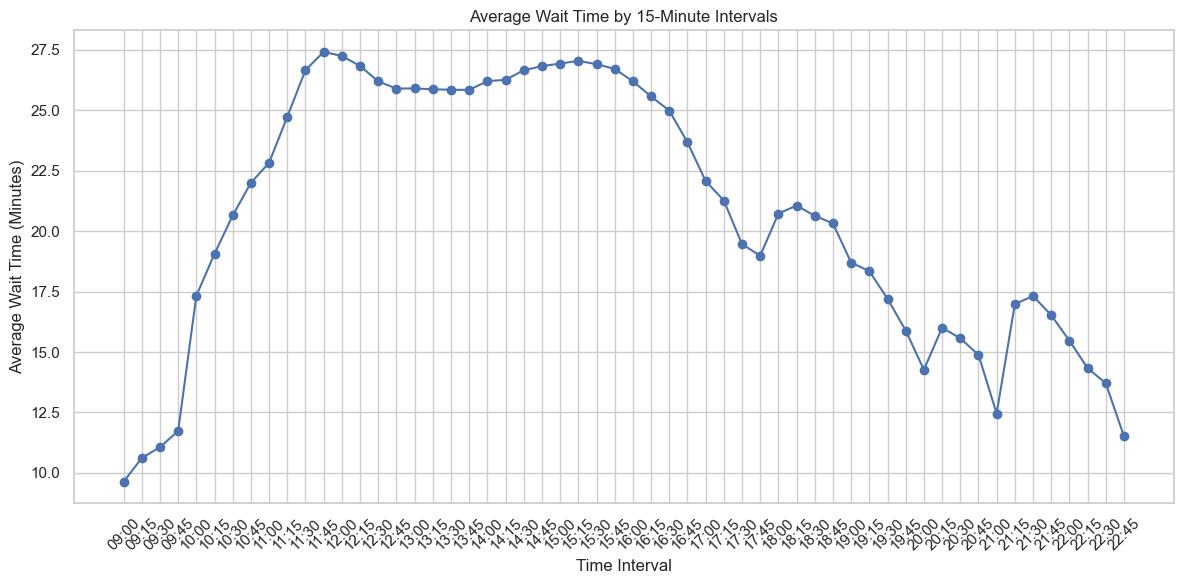

In [210]:
df_15_bis['START OF 1 RIDE FOR ATTRACTION'] = pd.to_datetime(df_15_bis['START OF 1 RIDE FOR ATTRACTION'])

df_15_bis['INTERVAL'] = df_15_bis['START OF 1 RIDE FOR ATTRACTION'].dt.hour * 4 + df_15_bis['START OF 1 RIDE FOR ATTRACTION'].dt.minute // 15

average_wait_time_by_interval = df_15_bis.groupby('INTERVAL')['WAIT TIME'].mean().reset_index()

average_wait_time_by_interval['TIME'] = average_wait_time_by_interval['INTERVAL'].apply(lambda x: f"{x//4:02d}:{(x%4)*15:02d}")

plt.figure(figsize=(12, 6))
plt.plot(average_wait_time_by_interval['TIME'], average_wait_time_by_interval['WAIT TIME'], marker='o', linestyle='-')
plt.title('Average Wait Time by 15-Minute Intervals')
plt.xlabel('Time Interval')
plt.ylabel('Average Wait Time (Minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [258]:
rush_hour_df = df_15_bis[(df_15_bis['HOUR START OF 1 RIDE'] > 9) & (df_15_bis['HOUR START OF 1 RIDE'] < 17)]
capacity_analysis = rush_hour_df.groupby('ATTRACTION NAME')['CAPACITY'].mean().reset_index()
capacity_analysis.sort_values(by = 'CAPACITY', inplace = True)

ratio_analysis = rush_hour_df.groupby('ATTRACTION NAME')['Ratio People/Capacity'].mean().reset_index()
ratio_analysis.sort_values(by = 'Ratio People/Capacity', inplace = True)

average_wait_time_by_attraction = rush_hour_df.groupby('ATTRACTION NAME')['WAIT TIME'].mean().reset_index()
average_wait_time_by_attraction.sort_values(by = 'WAIT TIME', inplace = True)

data_frames = [ratio_analysis, capacity_analysis, average_wait_time_by_attraction]
combined_analysis = reduce(lambda left, right: pd.merge(left, right, on='ATTRACTION NAME'), data_frames)

combined_analysis.sort_values('WAIT TIME', ascending= False)

,ATTRACTION NAME,Ratio People/Capacity,CAPACITY,WAIT TIME
12,Free Fall,0.558111,134.749000,57.087928
13,Spiral Slide,0.579466,75.000000,47.538779
8,Swing Ride,0.511300,242.250000,42.779330
22,Giant Wheel,0.654361,503.750000,42.262183
19,Zipline,0.616936,101.250000,40.187699
23,Go-Karts,0.681432,450.481668,34.730926
20,Drop Tower,0.631253,140.250000,34.200089
10,Vertical Drop,0.540462,411.250000,30.771277
1,Roller Coaster,0.366788,74.995096,28.200339
9,Water Ride,0.515618,244.546022,27.138398


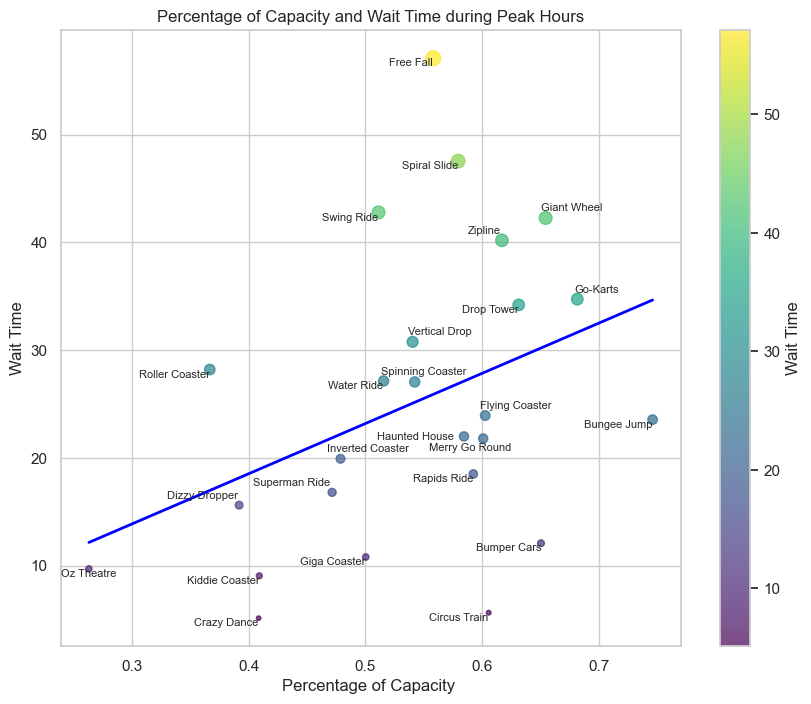

In [259]:
attraction_names = combined_analysis['ATTRACTION NAME']
ratio_people_capacity = combined_analysis['Ratio People/Capacity']
wait_time = combined_analysis['WAIT TIME']

plt.figure(figsize=(10, 8))
scatter = plt.scatter(ratio_people_capacity, wait_time, c=wait_time, cmap='viridis', s=wait_time*2, alpha=0.7)

regression_model = LinearRegression()
X = ratio_people_capacity.values.reshape(-1, 1)
y = wait_time.values
regression_model.fit(X, y)
regression_line = regression_model.predict(X)

plt.plot(ratio_people_capacity, regression_line, color='blue', linewidth=2, label='Linear Regression Line')

plt.title('Percentage of Capacity and Wait Time during Peak Hours')
plt.xlabel('Percentage of Capacity ')
plt.ylabel('Wait Time')

cbar = plt.colorbar(scatter)
cbar.set_label('Wait Time')

texts = [plt.text(ratio_people_capacity[i], wait_time[i], txt, fontsize=8, ha='center', va='bottom') for i, txt in enumerate(attraction_names)]

adjust_text(texts)

plt.show()



/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3635/586757078.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  free_fall = free_fall.groupby('DATE').mean()


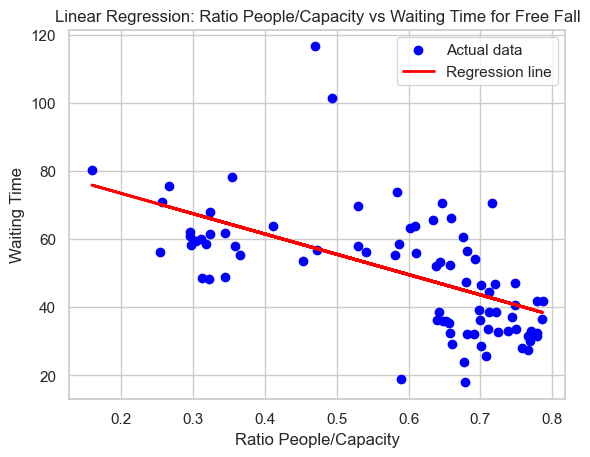

In [261]:
free_fall = df_15_bis[df_15_bis['ATTRACTION NAME'] == 'Free Fall']
free_fall = free_fall.groupby('DATE').mean()
X = free_fall[['Ratio People/Capacity']]
y = free_fall['WAIT TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel('Ratio People/Capacity')
plt.ylabel('Waiting Time')
plt.title('Linear Regression: Ratio People/Capacity vs Waiting Time for Free Fall')
plt.legend()
plt.show()


/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3635/1256802208.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  swing_ride = swing_ride.groupby('DATE').mean()


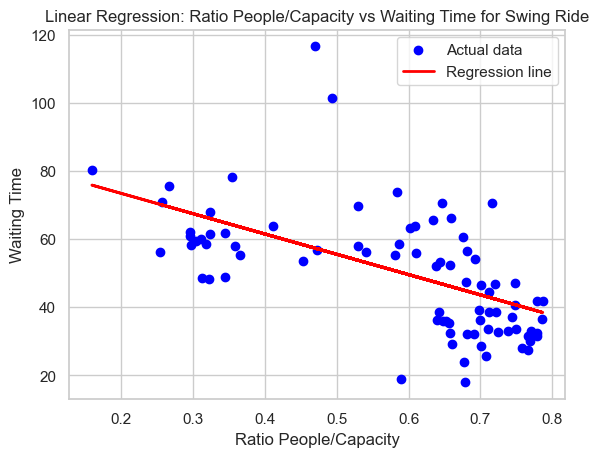

In [262]:
swing_ride = df_15_bis[df_15_bis['ATTRACTION NAME'] == 'Free Fall']
swing_ride = swing_ride.groupby('DATE').mean()
X = swing_ride[['Ratio People/Capacity']]
y = swing_ride['WAIT TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel('Ratio People/Capacity')
plt.ylabel('Waiting Time')
plt.title('Linear Regression: Ratio People/Capacity vs Waiting Time for Swing Ride')
plt.legend()
plt.show()

/var/folders/bv/5s8wgnqx04n66t4k9rrp0ygh0000gn/T/ipykernel_3635/4139651910.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  swing_ride = swing_ride.groupby('DATE').mean()


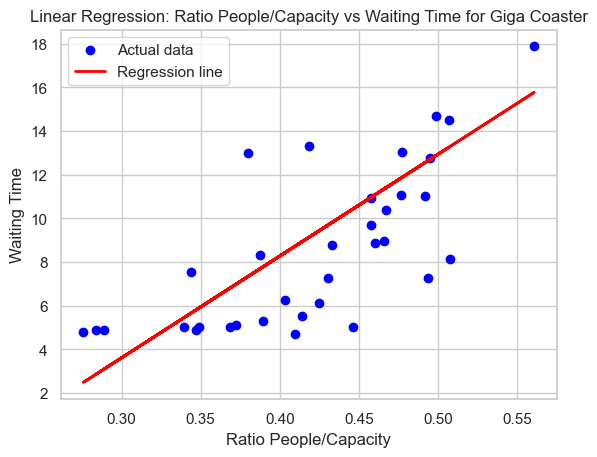

In [263]:
swing_ride = df_15_bis[df_15_bis['ATTRACTION NAME'] == 'Giga Coaster']
swing_ride = swing_ride.groupby('DATE').mean()
X = swing_ride[['Ratio People/Capacity']]
y = swing_ride['WAIT TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel('Ratio People/Capacity')
plt.ylabel('Waiting Time')
plt.title('Linear Regression: Ratio People/Capacity vs Waiting Time for Giga Coaster')
plt.legend()
plt.show()

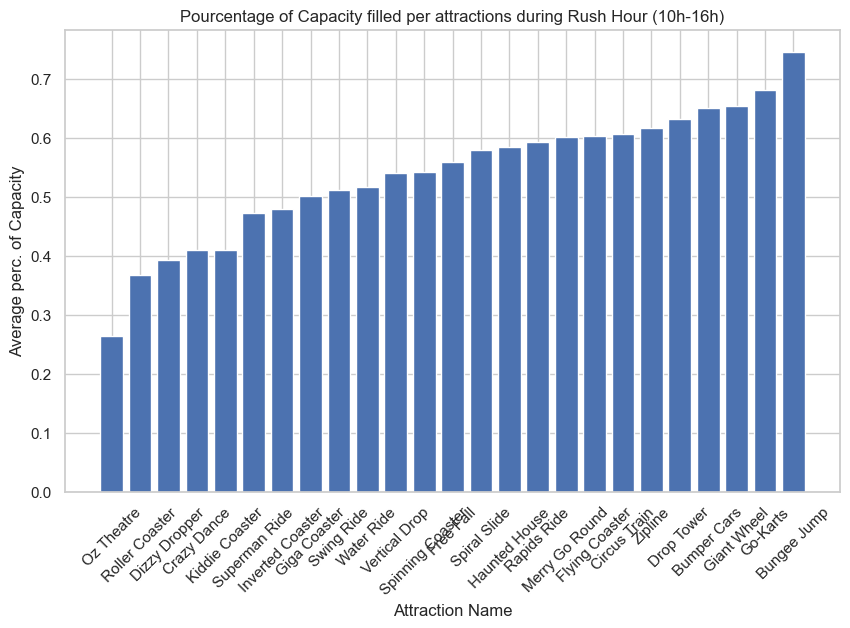

In [213]:
plt.figure(figsize=(10, 6))
plt.bar(ratio_analysis['ATTRACTION NAME'], ratio_analysis['Ratio People/Capacity'])
plt.xlabel('Attraction Name')
plt.ylabel('Average perc. of Capacity')
plt.title('Pourcentage of Capacity filled per attractions during Rush Hour (10h-16h)')
plt.xticks(rotation=45)
plt.show(10)

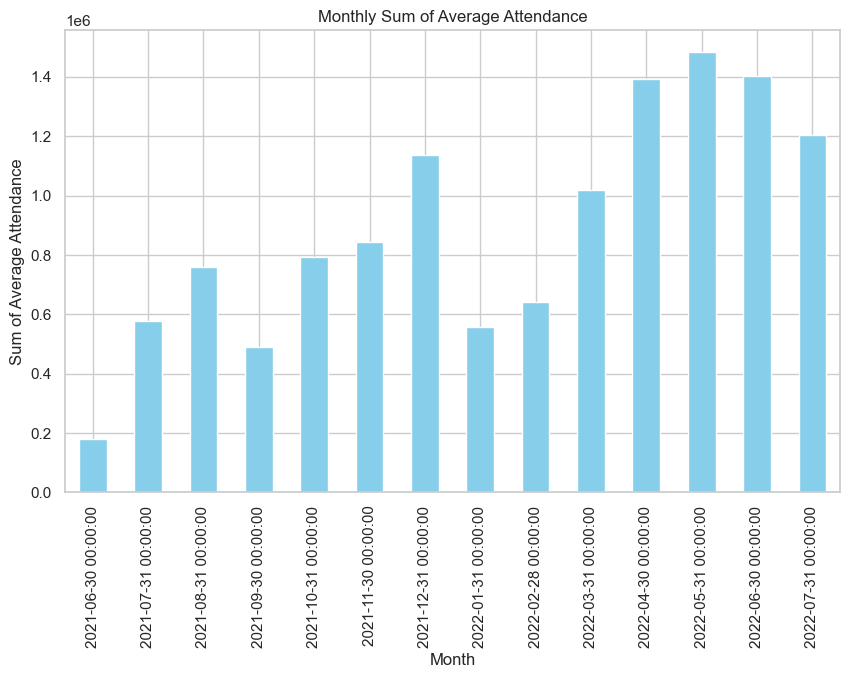

In [214]:
daily_average = df_15_bis.groupby('DATE')['ATTENDANCE'].mean()

monthly_sum = daily_average.resample('M').sum()

plt.figure(figsize=(10, 6))
monthly_sum.plot(kind='bar', color='skyblue')
plt.title('Monthly Sum of Average Attendance')
plt.xlabel('Month')
plt.ylabel('Sum of Average Attendance')
plt.show()

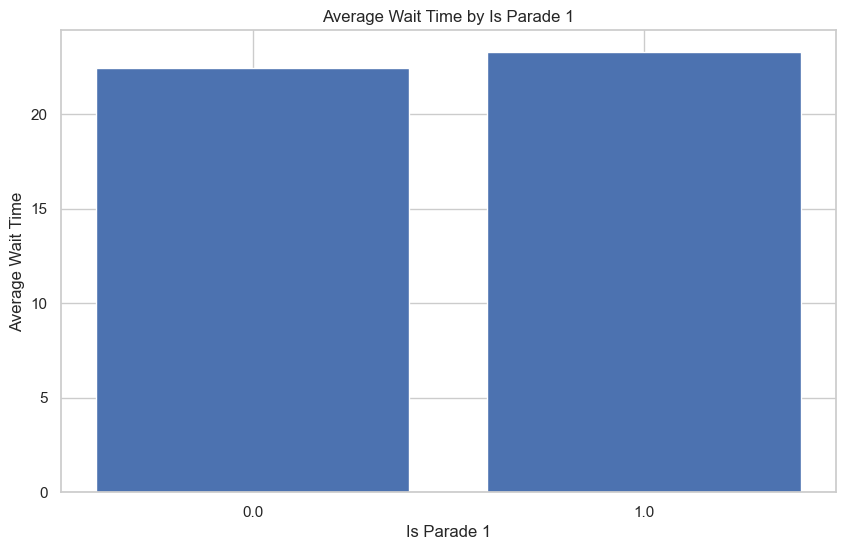

In [215]:
average_wait_time_by_parade1 = df_15_bis.groupby('IS PARADE 1')['WAIT TIME'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(average_wait_time_by_parade1['IS PARADE 1'].astype(str), average_wait_time_by_parade1['WAIT TIME'])
plt.xlabel('Is Parade 1')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time by Is Parade 1')
plt.show()


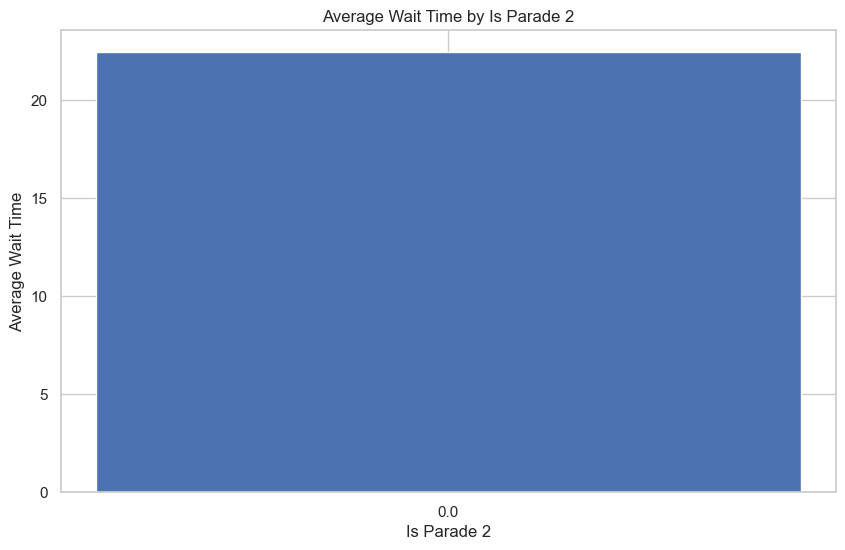

In [216]:
average_wait_time_by_parade1 = df_15_bis.groupby('IS PARADE 2')['WAIT TIME'].mean().reset_index()

# 
plt.figure(figsize=(10, 6))
plt.bar(average_wait_time_by_parade1['IS PARADE 2'].astype(str), average_wait_time_by_parade1['WAIT TIME'])
plt.xlabel('Is Parade 2')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time by Is Parade 2')
plt.show()

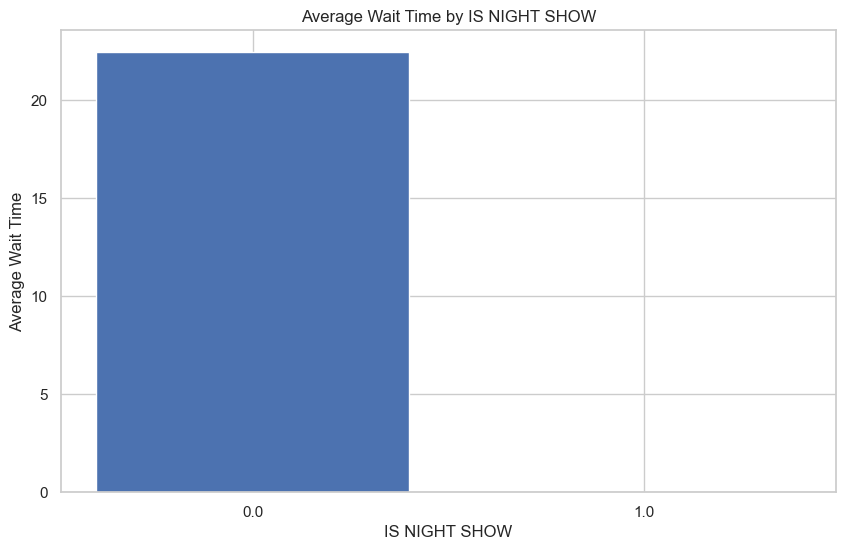

In [217]:
average_wait_time_by_parade1 = df_15_bis.groupby('IS NIGHT SHOW')['WAIT TIME'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(average_wait_time_by_parade1['IS NIGHT SHOW'].astype(str), average_wait_time_by_parade1['WAIT TIME'])
plt.xlabel('IS NIGHT SHOW')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time by IS NIGHT SHOW')
plt.show()